In [19]:
import pandas as pd
import numpy as np
import os
import keras
import sklearn
import json
import requests
import datetime
from scipy.spatial.distance import pdist

import plotly.plotly

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import OneHotEncoder

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten

In [3]:
datadir = '../data/plows/v0/raw'
files = os.listdir(datadir)
gc_key = os.environ['GEOCODING_SECRET_KEY']
file = 'plow20180101.csv'
address = '700 Stinard Avenue, Syracuse, NY 13207'

In [4]:
res = requests.get('https://maps.googleapis.com/maps/api/geocode/json?address={}&key={}'.format(address,gc_key))
results = res.json()['results'][0]
lat = results['geometry']['location']['lat']
long = results['geometry']['location']['lng']

In [5]:
data = []
for f in files:
    data.append(pd.read_csv(os.path.join(datadir, f)))
    


/home/paul/.virtualenvs/snowplow/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
 for e in data:
    e.drop(['X', 'Y', 'OBJECTID', 'date_fixed1', 'Unnamed: 0', 'Unnamed: 2'], errors='ignore', axis=1, inplace=True)
    display(e.head())
    display(e.shape)



,truck_name,repair_type,date_fixed,strHeading,address,activity_type,longitude,latitude
0,178.0,SNOW & ICE,2018-01-08 00:00:07.000,E,306 SENECA TNPK E TO ARSENAL ...,Stop Moving,-76.138107,42.999824
1,178.0,SNOW & ICE,2018-01-08 00:01:07.000,E,106 ARSENAL DR ...,,-76.138110,42.999739
2,178.0,SNOW & ICE,2018-01-08 00:02:07.000,E,306 SENECA TNPK E TO ARSENAL ...,,-76.138090,42.999786
3,178.0,SNOW & ICE,2018-01-08 00:03:07.000,E,121 ARSENAL DR ...,,-76.137820,42.999810
4,178.0,SNOW & ICE,2018-01-08 00:03:09.000,E,121 ARSENAL DR ...,Start Moving,-76.137770,42.999808


(49002, 8)

,truck_name,repair_type,date_fixed,strHeading,address,activity_type,longitude,latitude
0,178,SNOW & ICE,2018-01-03 00:00:14.000,W,360 SENECA TNPK W & VALLEY DR ...,NaN,-76.152760,43.002059
1,178,SNOW & ICE,2018-01-03 00:00:19.000,W,360 SENECA TNPK W & VALLEY DR ...,Stop Moving,-76.152973,43.002085
2,178,SNOW & ICE,2018-01-03 00:00:29.000,N,1524 VALLEY DR ...,Start Moving,-76.153132,43.002572
3,178,SNOW & ICE,2018-01-03 00:01:29.000,N,831 VALLEY DR ...,NaN,-76.156007,43.008522
4,178,SNOW & ICE,2018-01-03 00:02:29.000,N,359-61 VALLEY DR & MEDORA PL ...,NaN,-76.159111,43.014451


(15184, 8)

,truck_name,repair_type,date_fixed,strHeading,address,activity_type,longitude,latitude
0,178.0,SNOW & ICE,2018-01-04 00:00:07.000,W,600 TEALL AVE & HAWLEY AVE ...,Stop Moving,-76.121721,43.055674
1,178.0,SNOW & ICE,2018-01-04 00:00:12.000,E,600 TEALL AVE & HAWLEY AVE ...,,-76.121709,43.055673
2,178.0,SNOW & ICE,2018-01-04 00:00:21.000,E,1611 HAWLEY AVE ...,Start Moving,-76.121250,43.055673
3,178.0,SNOW & ICE,2018-01-04 00:00:52.000,S,307 GREENWAY AVE & HAWLEY AVE ...,,-76.119447,43.055584
4,178.0,SNOW & ICE,2018-01-04 00:01:06.000,E,1401-07 BURNET AVE & GREENWAY AVE ...,,-76.119222,43.055041


(49382, 8)

,truck_name,repair_type,date_fixed,strHeading,address,activity_type,longitude,latitude
0,178.0,SNOW & ICE,2018-01-06 00:00:13.000,S,340 FOREST HILL DR ...,Start Moving,-76.110893,43.062523
1,178.0,SNOW & ICE,2018-01-06 00:00:29.000,S,352 FOREST HILL DR ...,Stop Moving,-76.110868,43.062189
2,178.0,SNOW & ICE,2018-01-06 00:00:49.000,S,364 FOREST HILL DR ...,Start Moving,-76.110824,43.061901
3,178.0,SNOW & ICE,2018-01-06 00:00:57.000,S,372 FOREST HILL DR & SUNNYCRE ...,Stop Moving,-76.110815,43.061738
4,178.0,SNOW & ICE,2018-01-06 00:01:07.000,W,372 FOREST HILL DR & SUNNYCRE ...,,-76.111005,43.061636


(59282, 8)

,truck_name,repair_type,date_fixed,address,activity_type,longitude,latitude
0,262,SNOW & ICE,2017-03-14 00:00:03.000,1824 EB I 690 SYRACUSE 13210 ...,,-76.110451,43.055597
1,210,SNOW & ICE,2017-03-14 00:00:06.000,1820 EB I 690 SYRACUSE 13210 ...,,-76.111169,43.055529
2,266,SNOW & ICE,2017-03-14 00:00:08.000,...,,-76.107321,43.055576
3,265,SNOW & ICE,2017-03-14 00:00:10.000,1241 CANAL ST SYRACUSE 13210 ...,,-76.111044,43.055424
4,261,SNOW & ICE,2017-03-14 00:00:19.000,1237 CANAL ST SYRACUSE 13210 ...,,-76.111649,43.055182


(65411, 7)

,truck_name,repair_type,date_fixed,address,activity_type,longitude,latitude
0,283,SNOW & ICE,2017-03-15 00:00:01.000,1216 CANAL ST REAR ...,Ignition On,-76.112274,43.054979
1,265,SNOW & ICE,2017-03-15 00:00:04.000,1212 CANAL ST ...,,-76.114741,43.054065
2,284,SNOW & ICE,2017-03-15 00:00:04.000,123 STANDART ST ...,Start Moving,-76.139915,43.034899
3,286,SNOW & ICE,2017-03-15 00:00:06.000,217 GEDDES ST S ...,,-76.171008,43.044902
4,266,SNOW & ICE,2017-03-15 00:00:07.000,404 TOWNSEND ST N & WILLOW ST ...,,-76.146576,43.054486


(65714, 7)

,truck_name,repair_type,date_fixed,address,activity_type,longitude,latitude
0,265,SNOW & ICE,2017-03-13 00:00:07.000,202 CATHERINE ST & BURNET AVE ...,Stop Moving,-76.142090,43.052366
1,283,SNOW & ICE,2017-03-13 00:00:10.000,484-98 SALINA ST S & ONONDAGA ST ...,Start Moving,-76.152678,43.044098
2,263,SNOW & ICE,2017-03-13 00:00:10.000,736 NEWELL ST W & VALLEY DR ...,NaN,-76.159828,43.015809
3,265,SNOW & ICE,2017-03-13 00:00:18.000,322-24 BURNET AVE & CATHERINE ST ...,Start Moving,-76.142112,43.052035
4,285,SNOW & ICE,2017-03-13 00:00:20.000,2430-50 JAMES ST & FOREST HILL DR ...,NaN,-76.111648,43.068500


(13389, 7)

,truck_name,repair_type,date_fixed,strHeading,address,activity_type,longitude,latitude
0,178.0,SNOW & ICE,2018-01-01 05:15:20.000,N,1200 CANAL ST ...,,-76.108890,43.055110
1,178.0,SNOW & ICE,2018-01-01 05:15:22.000,N,1200 CANAL ST ...,Ignition On,-76.108890,43.055110
2,178.0,SNOW & ICE,2018-01-01 05:16:22.000,N,1200 CANAL ST ...,,-76.108890,43.055110
3,178.0,SNOW & ICE,2018-01-01 05:17:22.000,N,1200 CANAL ST ...,,-76.108805,43.055128
4,178.0,SNOW & ICE,2018-01-01 05:18:22.000,W,1200 CANAL ST ...,,-76.108779,43.055191


(39784, 8)

,truck_name,repair_type,date_fixed,strHeading,address,activity_type,longitude,latitude
0,178.0,SNOW & ICE,2018-01-09 10:46:59.000,E,1200 CANAL ST ...,,-76.110183,43.055762
1,178.0,SNOW & ICE,2018-01-09 10:47:01.000,E,1200 CANAL ST ...,Ignition On,-76.110183,43.055762
2,178.0,SNOW & ICE,2018-01-09 10:48:00.000,E,1200 CANAL ST ...,,-76.110183,43.055762
3,178.0,SNOW & ICE,2018-01-09 10:48:32.000,E,1200 CANAL ST ...,Ignition Off,-76.110183,43.055762
4,178.0,SNOW & ICE,2018-01-09 10:49:32.000,E,1200 CANAL ST ...,,-76.110183,43.055762


(37285, 8)

,truck_name,repair_type,date_fixed,strHeading,address,activity_type,longitude,latitude
0,178.0,SNOW & ICE,2018-01-02 00:00:42.000,E,1200 CANAL ST ...,,-76.109170,43.055308
1,178.0,SNOW & ICE,2018-01-02 00:01:42.000,E,1200 CANAL ST ...,,-76.109168,43.055296
2,178.0,SNOW & ICE,2018-01-02 00:02:42.000,E,1200 CANAL ST ...,,-76.109152,43.055293
3,178.0,SNOW & ICE,2018-01-02 00:03:42.000,E,1200 CANAL ST ...,,-76.109187,43.055287
4,178.0,SNOW & ICE,2018-01-02 00:04:42.000,E,1200 CANAL ST ...,,-76.109163,43.055270


(40791, 8)

,truck_name,repair_type,date_fixed,strHeading,address,activity_type,longitude,latitude
0,178.0,SNOW & ICE,2018-01-07 00:00:57.000,W,2206 GRANT BLVD ...,,-76.144832,43.073097
1,178.0,SNOW & ICE,2018-01-07 00:01:57.000,W,2601 GRANT BLVD & DANFORTH ST ...,,-76.151995,43.074399
2,178.0,SNOW & ICE,2018-01-07 00:02:22.000,SW,813 COURT ST & GRANT BLVD ...,Stop Moving,-76.153885,43.074306
3,178.0,SNOW & ICE,2018-01-07 00:02:33.000,SE,816 COURT ST & COURT TERR ...,,-76.153794,43.074172
4,178.0,SNOW & ICE,2018-01-07 00:03:03.000,SE,124 COURT TERR ...,Start Moving,-76.153321,43.073932


(47696, 8)

In [7]:
df = pd.concat(data)
df.reset_index(inplace=True, drop=True)
df.head()
display(df.tail())

,activity_type,address,date_fixed,latitude,longitude,repair_type,strHeading,truck_name
482915,,1030 MONTGOMERY ST ...,2018-01-07 23:55:32.000,43.036477,-76.148582,SNOW & ICE,S,73
482916,,1030 MONTGOMERY ST ...,2018-01-07 23:56:32.000,43.036497,-76.148625,SNOW & ICE,S,73
482917,,1030 MONTGOMERY ST ...,2018-01-07 23:57:32.000,43.036506,-76.148642,SNOW & ICE,S,73
482918,,1030 MONTGOMERY ST ...,2018-01-07 23:58:32.000,43.036521,-76.148630,SNOW & ICE,S,73
482919,,1030 MONTGOMERY ST ...,2018-01-07 23:59:32.000,43.036496,-76.148617,SNOW & ICE,S,73


In [8]:
time_objects = list(map(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f').time().strftime('%H:%M:%S'), df['date_fixed']))
date_objects = list(map(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f').date().strftime('%m/%d/%Y'), df['date_fixed']))

df = df.assign(time=time_objects , date=date_objects).drop(['date_fixed'], axis=1)

In [26]:
df.head()
df.to_csv('../data/plows/v0/clean/f')

,activity_type,address,latitude,longitude,repair_type,strHeading,truck_name,time,date
0,Stop Moving,306 SENECA TNPK E TO ARSENAL ...,42.999824,-76.138107,SNOW & ICE,E,178,00:00:07,01/08/2018
1,,106 ARSENAL DR ...,42.999739,-76.138110,SNOW & ICE,E,178,00:01:07,01/08/2018
2,,306 SENECA TNPK E TO ARSENAL ...,42.999786,-76.138090,SNOW & ICE,E,178,00:02:07,01/08/2018
3,,121 ARSENAL DR ...,42.999810,-76.137820,SNOW & ICE,E,178,00:03:07,01/08/2018
4,Start Moving,121 ARSENAL DR ...,42.999808,-76.137770,SNOW & ICE,E,178,00:03:09,01/08/2018


In [16]:
trainX = df[['latitude', 'longitude']][:int(df.shape[0]/2)]
testX = df[['latitude', 'longitude']][int(df.shape[0]/2):]

In [21]:
model = GaussianMixture(n_components=8)
model.fit(trainX)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=8, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [22]:
model.predict(testX)
model.bic(testX)

-2494767.696850235

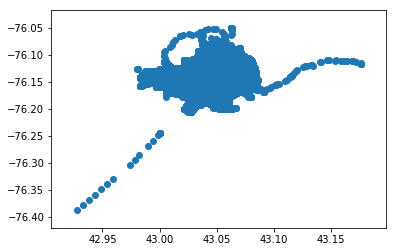

In [25]:
plt.scatter(testX['latitude'], testX['longitude'])
xmin = 42.925
xmax = 43.1
ymin = -76.25
ymax = -76


In [30]:
df['activity_type'].unique()

array(['    Stop Moving', '    ', '    Start Moving', '    Ignition Off',
       '    Ignition On', '    Aux Motor off', '    Aux Motor On',
       '  Aux Motor off  Stop Moving', '  Start Moving  Aux Motor On',
       '  Aux Motor On  Stop Moving', '  Start Moving  Aux Motor off',
       '    Spreader On', '    Spreader Off', '    Plow Up',
       '    Plow Down', '  Spreader Off  Stop Moving',
       '  Start Moving  Spreader On', '  Spreader On  Stop Moving',
       '  Plow Up  Stop Moving', '  Start Moving  Spreader Off',
       '  Start Moving  Plow Down', '  Start Moving  Ignition On',
       '  Start Moving  Plow Up', '  Plow Down  Stop Moving', nan,
       '  Stop Moving  Ignition On'], dtype=object)

In [31]:
trucks = df['truck_name'].unique()
len(trucks)

68

In [ ]:
df[]